# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [238]:
import warnings
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams

df = pd.read_csv('zillow_data.csv')

In [239]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


Picking zip codes to invest in:


https://www.businessinsider.com/us-metro-area-city-best-economy-ranking-2019-8#1-san-francisco-california-the-per-capita-gdp-of-90296-and-average-weekly-wage-of-1932-were-both-by-far-the-highest-among-the-30-biggest-metro-areas-and-the-unemployment-rate-of-22-was-tied-with-austin-as-the-lowest-15

Pick top 5 from article
Then find the best zipcode to invest in each one

1. San Francisco
2. Austin
3. Seattle
4. Dallas
5. Boston

# Step 2: Data Preprocessing

In [241]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [242]:
#returns 3 smallest 
def three_smallest(df):
    return df.nsmallest(3, '2018-04')

In [243]:
san_fran_df = three_smallest(df[df['Metro'] == 'San Francisco'])
austin_df = three_smallest(df[df['Metro'] == 'Austin'])
seattle_df = three_smallest(df[df['Metro'] == 'Seattle'])
dallas_df = three_smallest(df[df['Metro'] == 'Dallas-Fort Worth'])
boston_df = three_smallest(df[df['Metro'] == 'Boston'])

How to determine what is the best zipcode in each metro area?
1. Find 3 lowest mean sale prices for the final columns 2018-4
2. Model these 3 and see if any of them has started to take off,  is easiest to predict, etc

In [244]:
dallas_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
12127,90957,75496,Wolfe City,TX,Dallas-Fort Worth,Hunt,12128,50500.0,50800.0,51200.0,...,66400,67500,68700,69100,69800,70400,70900,71500,72500,73300
9356,90763,75210,Dallas,TX,Dallas-Fort Worth,Dallas,9357,NaN,NaN,NaN,...,67000,66800,66400,66600,68400,70900,72900,75100,76900,77300
6033,91250,76105,Fort Worth,TX,Dallas-Fort Worth,Tarrant,6034,33100.0,33600.0,34100.0,...,70700,72900,75000,76400,76400,76400,76800,77400,78300,78800


# Step 3: EDA and Visualization

In [245]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [246]:
def city_plot(df, start_year, title):
    df_plot = df[['RegionName', start_year, '2018-04']]
    df_plot.plot.bar(x='RegionName', figsize=(8,8), title=title)
    plt.show()

In [247]:
def city_roi(df, start_year):
    df['roi'] = df['2018-04'] - df[start_year]
    zipcode = df['RegionName'].ravel()
    roi = (df['2018-04'] - df[start_year]).ravel()
    for i in range(len(roi)):
        print('From', start_year[:4], 'to 2018, the average return for zip-code {} was: ${}'.format(zipcode[i], roi[i]))
    return zipcode[roi.tolist().index(roi.max())]

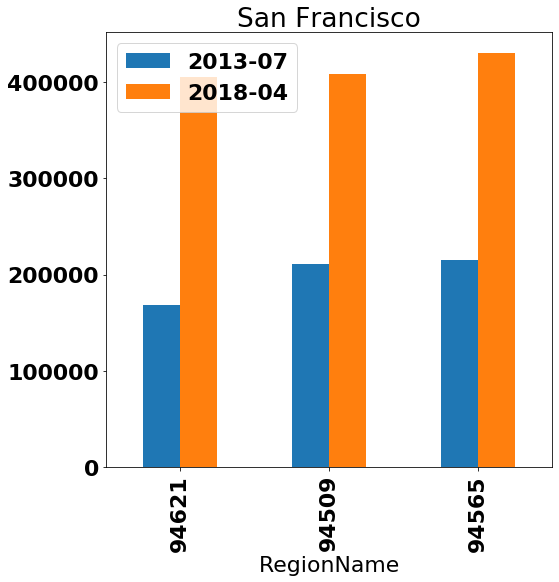

From 2013 to 2018, the average return for zip-code 94621 was: $236600.0
From 2013 to 2018, the average return for zip-code 94509 was: $198200.0
From 2013 to 2018, the average return for zip-code 94565 was: $214600.0


In [248]:
#Plot each city individually calling the city_plot function
city_plot(san_fran_df, '2013-07', 'San Francisco')
#Shows the returns for each zipcode, returns zip with highest return
san_fran_largest_return = city_roi(san_fran_df, '2013-07')

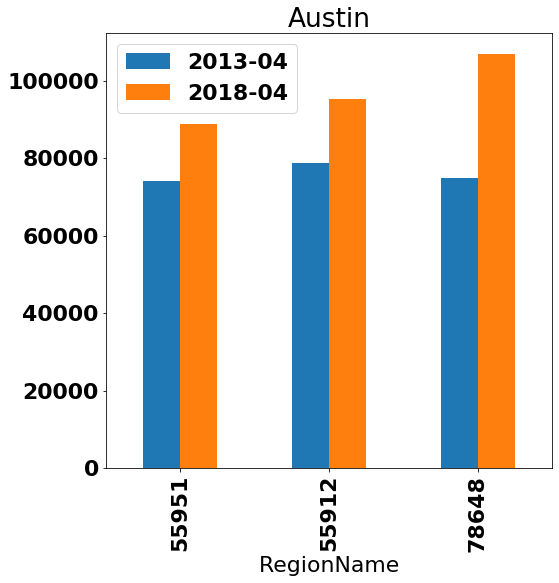

From 2013 to 2018, the average return for zip-code 55951 was: $14600.0
From 2013 to 2018, the average return for zip-code 55912 was: $16400.0
From 2013 to 2018, the average return for zip-code 78648 was: $32000.0


In [249]:
city_plot(austin_df, '2013-04', 'Austin')
austin_largest_return = city_roi(austin_df, '2013-04')

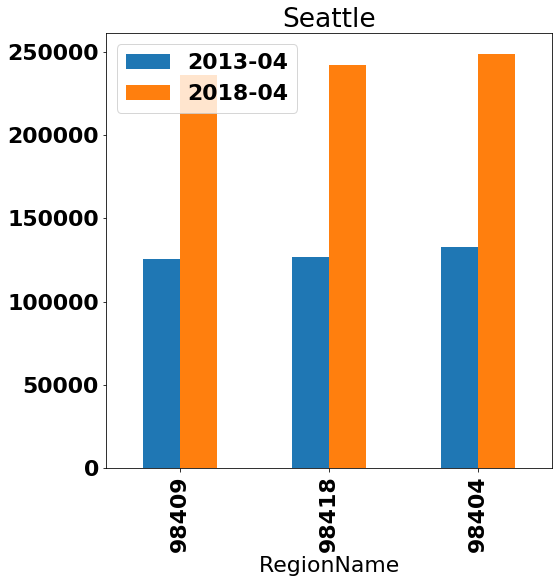

From 2013 to 2018, the average return for zip-code 98409 was: $110500.0
From 2013 to 2018, the average return for zip-code 98418 was: $115400.0
From 2013 to 2018, the average return for zip-code 98404 was: $116000.0


In [250]:
city_plot(seattle_df, '2013-04', 'Seattle')
seattle_largest_return = city_roi(seattle_df, '2013-04')

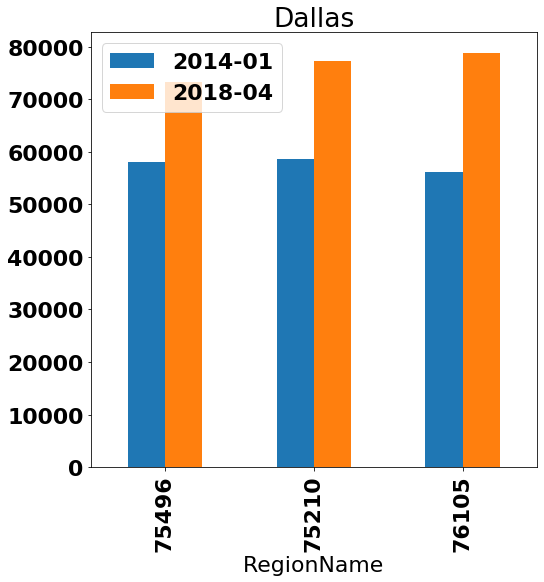

From 2014 to 2018, the average return for zip-code 75496 was: $15200.0
From 2014 to 2018, the average return for zip-code 75210 was: $18700.0
From 2014 to 2018, the average return for zip-code 76105 was: $22700.0


In [251]:
city_plot(dallas_df, '2014-01', 'Dallas')
dallas_largest_return = city_roi(dallas_df, '2014-01')

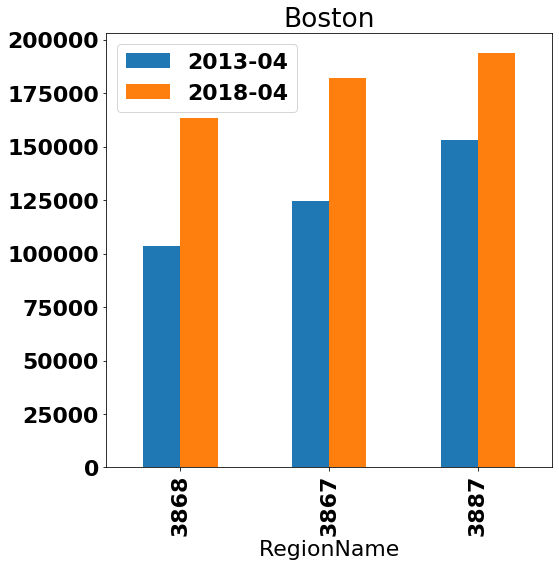

From 2013 to 2018, the average return for zip-code 3868 was: $59900.0
From 2013 to 2018, the average return for zip-code 3867 was: $57700.0
From 2013 to 2018, the average return for zip-code 3887 was: $40500.0


In [252]:
city_plot(boston_df, '2013-04', 'Boston')
boston_largest_return = city_roi(boston_df, '2013-04')

# Step 4: Reshape from Wide to Long Format

In [253]:
#delete the groupyby to have all the zipcodes and not just the mean values and dates

def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 
                                  'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted
#     return melted.groupby('time').aggregate({'value':'mean'})

In [254]:
def get_df_to_model(df, zipcode):
    df = df.drop(columns=['roi'])
    melted_df = melt_data(df)
    model_df = melted_df[melted_df['RegionName'] == zipcode]
    model_df.set_index(model_df['time'], inplace=True)
    model_df.drop(['time'], axis=1, inplace=True)
    model_df = model_df.asfreq('MS')
    model_df.drop(['City', 'State', 'Metro', 'CountyName', 'RegionName', 
                   'RegionID', 'SizeRank'], axis=1,  inplace=True)
    model_df.plot(figsize=(15,6))
    plt.show()
    return model_df

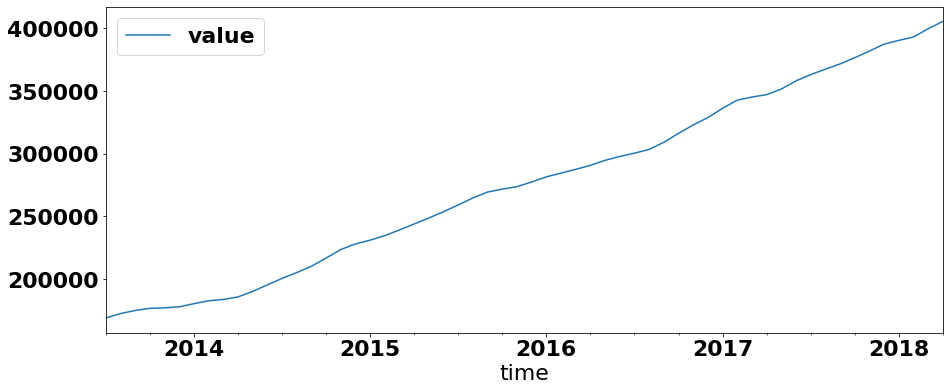

In [255]:
san_fran_model_df = get_df_to_model(san_fran_df, san_fran_largest_return)

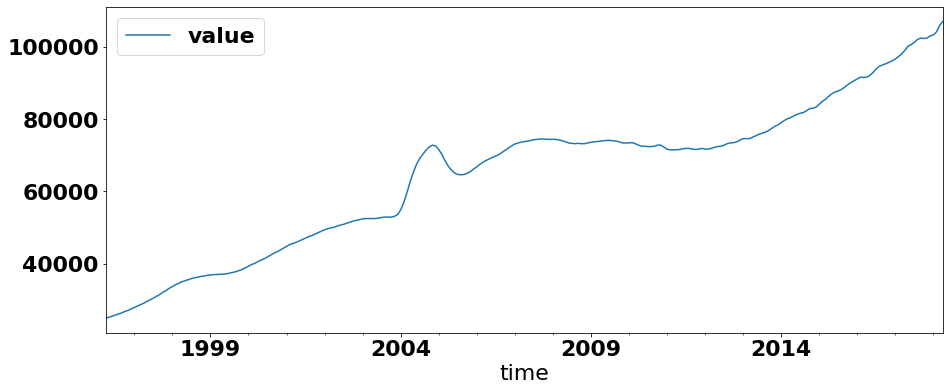

In [256]:
austin_model_df = get_df_to_model(austin_df, austin_largest_return)

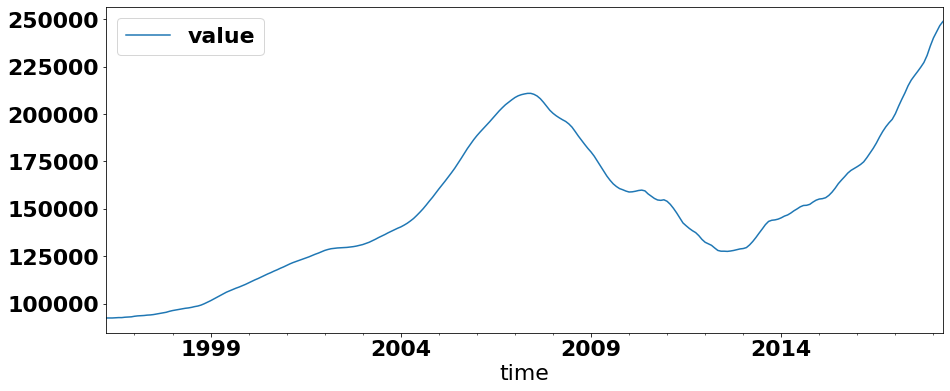

In [257]:
seattle_model_df = get_df_to_model(seattle_df, seattle_largest_return)

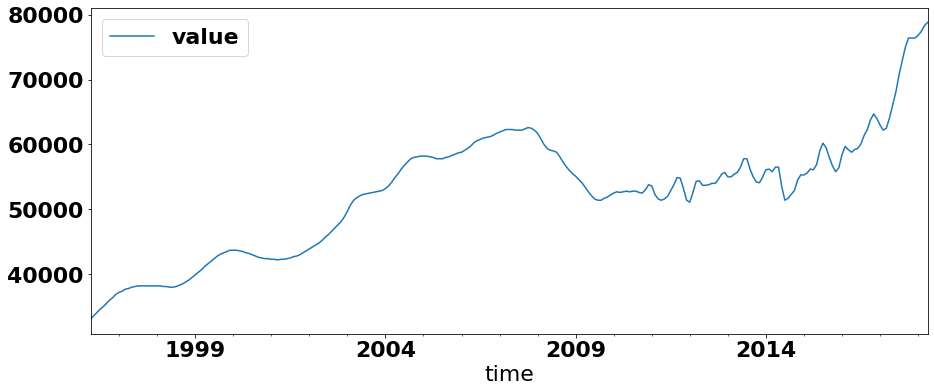

In [258]:
dallas_model_df = get_df_to_model(dallas_df, dallas_largest_return)

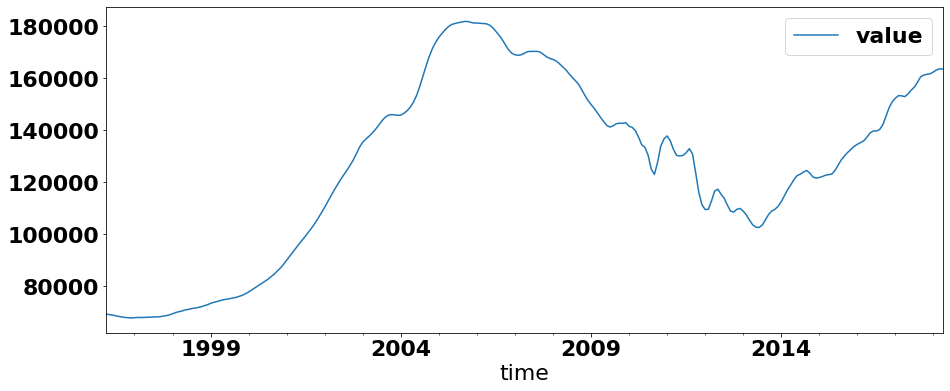

In [259]:
boston_model_df = get_df_to_model(boston_df, boston_largest_return)

# Step 5: ARIMA Modeling

In [274]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

evaluate_models(san_fran_model_df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=11520374938.290
ARIMA(0, 0, 1) MSE=2959423357.443
ARIMA(0, 1, 0) MSE=3927307.037
ARIMA(0, 1, 1) MSE=2098017.863
ARIMA(0, 2, 0) MSE=3366200.573
ARIMA(0, 2, 1) MSE=3199235.200
ARIMA(1, 0, 0) MSE=29628082.698
ARIMA(1, 1, 0) MSE=2794763.237
ARIMA(1, 1, 2) MSE=1786213.612
ARIMA(1, 2, 0) MSE=3447819.342
ARIMA(1, 2, 1) MSE=3161561.841
ARIMA(2, 0, 0) MSE=3609442.455
ARIMA(2, 1, 0) MSE=2478609.698
ARIMA(2, 1, 1) MSE=2210146.676
ARIMA(2, 1, 2) MSE=2093805.015
ARIMA(2, 2, 0) MSE=2194802.397
ARIMA(2, 2, 1) MSE=2263177.105
ARIMA(2, 2, 2) MSE=2494034.726
ARIMA(4, 1, 0) MSE=2038043.790
ARIMA(4, 1, 1) MSE=2250791.330
ARIMA(4, 2, 0) MSE=2382504.034
ARIMA(6, 2, 0) MSE=2546188.028
Best ARIMA(1, 1, 2) MSE=1786213.612


In [273]:
#Combine these two functions()

In [263]:
#define p, d, q
p = range(0, 13)
d = q = range(0, 2)

#Generate all combinations of p,d,q
pdq = list(itertools.product(p, d, q))

In [209]:
#run ARIMA, plot, predict, MSE
def basic_arima_test(df):
    #get pdq with lowest AIC
    ans = []
    for comb in pdq:
        mod = sm.tsa.statespace.SARIMAX(df, order=comb, enforce_stationarity=False,
                                        enforce_invertibility=False)
        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Caluculated ={}'.format(comb, output.aic))
        
    ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
    value = ans_df.loc[ans_df['aic'].idxmin()]
    print('The lowest AIC value is', value.aic, 'with a p, d, q of', value.pdq)

    #The ARIMA model and summary table
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df,
                                        order=value.pdq,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
    output = ARIMA_MODEL.fit()
    print(output.summary().tables[1])
    
    #plot diagnositcs
    output.plot_diagnostics(figsize=(14,18))
    plt.gcf().autofmt_xdate()
    plt.show()
    
    #get predictions from 2017-01 to 2018-04
    pred = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
    pred_conf = pred.conf_int()
    
    # Plot real vs predicted values along with confidence interval
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = df['1996':].plot(label='observed')

    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    plt.legend()

    plt.show()
    
    # Compute the mean square error
    value_forecasted = pred.predicted_mean
    value_truth = df['2017-01-01':]
    mse = ((value_forecasted - value_truth['value']) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    
    #dynamic modeling
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    
    ax = df['1996':].plot(label='observed', figsize=(20, 15))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), value_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Values')

    plt.legend()
    plt.show()
    
    # Compute the mean square error
    value_forecasted = pred_dynamic.predicted_mean
    value_truth = df['2017-01-01':]
    mse = ((value_forecasted - value_truth['value']) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    
    #forecasting
    prediction = output.get_forecast(steps=100)
    pred_conf = prediction.conf_int()
    
    ax = df.plot(label='observed', figsize=(20, 15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')

    plt.legend()
    plt.show()

ARIMA (0, 0, 0) : AIC Caluculated =1596.6546731233527
ARIMA (0, 0, 1) : AIC Caluculated =1531.83743044851
ARIMA (0, 0, 2) : AIC Caluculated =1499.213463334662
ARIMA (0, 1, 0) : AIC Caluculated =1102.926114805748
ARIMA (0, 1, 1) : AIC Caluculated =1020.9718520191209
ARIMA (0, 1, 2) : AIC Caluculated =951.7977989136614
ARIMA (0, 2, 0) : AIC Caluculated =953.3172714786879
ARIMA (0, 2, 1) : AIC Caluculated =932.7084375477327
ARIMA (0, 2, 2) : AIC Caluculated =914.9058196954138
ARIMA (1, 0, 0) : AIC Caluculated =1009.0536105792893
ARIMA (1, 0, 1) : AIC Caluculated =952.8773762198799
ARIMA (1, 0, 2) : AIC Caluculated =923.6493646477923
ARIMA (1, 1, 0) : AIC Caluculated =971.2832106342825
ARIMA (1, 1, 1) : AIC Caluculated =954.3644421479273
ARIMA (1, 1, 2) : AIC Caluculated =931.6104798554015
ARIMA (1, 2, 0) : AIC Caluculated =953.9204460664906
ARIMA (1, 2, 1) : AIC Caluculated =930.724135888096
ARIMA (1, 2, 2) : AIC Caluculated =914.7680705285527
ARIMA (2, 0, 0) : AIC Caluculated =963.799130

C:\Users\Andy\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) : AIC Caluculated =956.523044703068
ARIMA (2, 1, 2) : AIC Caluculated =932.5247295936938
ARIMA (2, 2, 0) : AIC Caluculated =911.054580634818
ARIMA (2, 2, 1) : AIC Caluculated =909.8549273080453
ARIMA (2, 2, 2) : AIC Caluculated =895.431224094744
The lowest AIC value is 895.431224094744 with a p, d, q of (2, 2, 2)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1210      0.191      0.634      0.526      -0.253       0.495
ar.L2         -0.7214      0.183     -3.935      0.000      -1.081      -0.362
ma.L1          0.2713      0.260      1.044      0.296      -0.238       0.780
ma.L2          0.0608      0.199      0.305      0.761      -0.330       0.451
sigma2      1.138e+06   2.44e+05      4.663      0.000     6.6e+05    1.62e+06


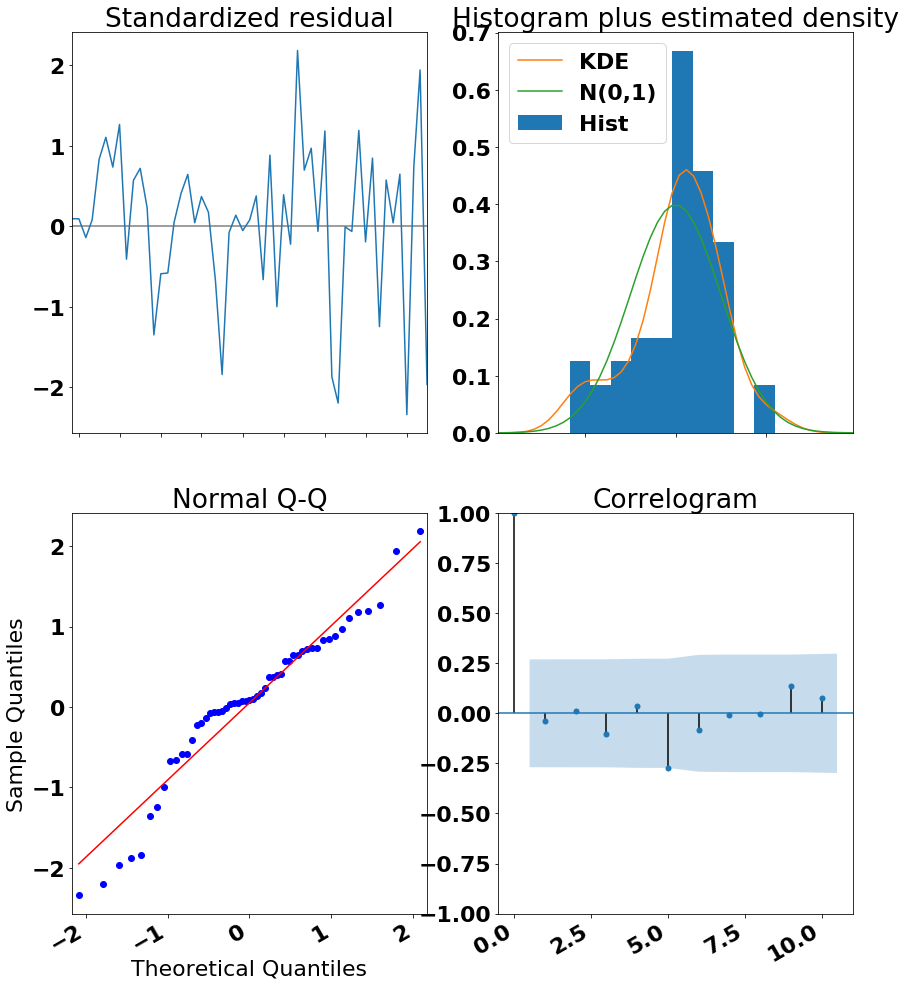

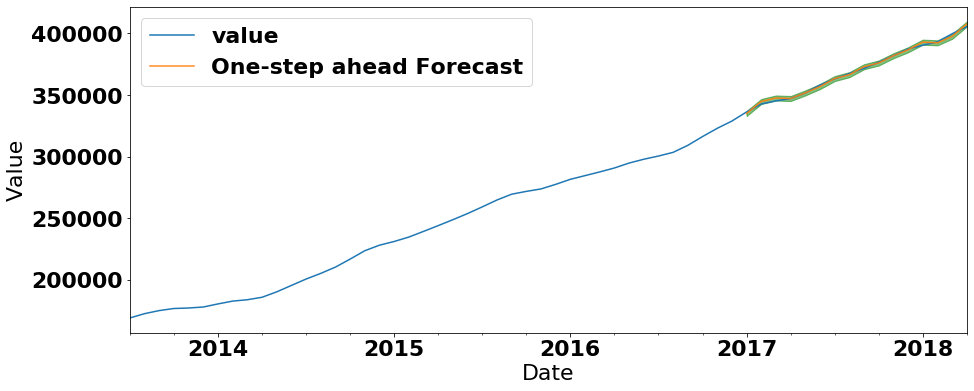

The Mean Squared Error of our forecasts is 1983411.24


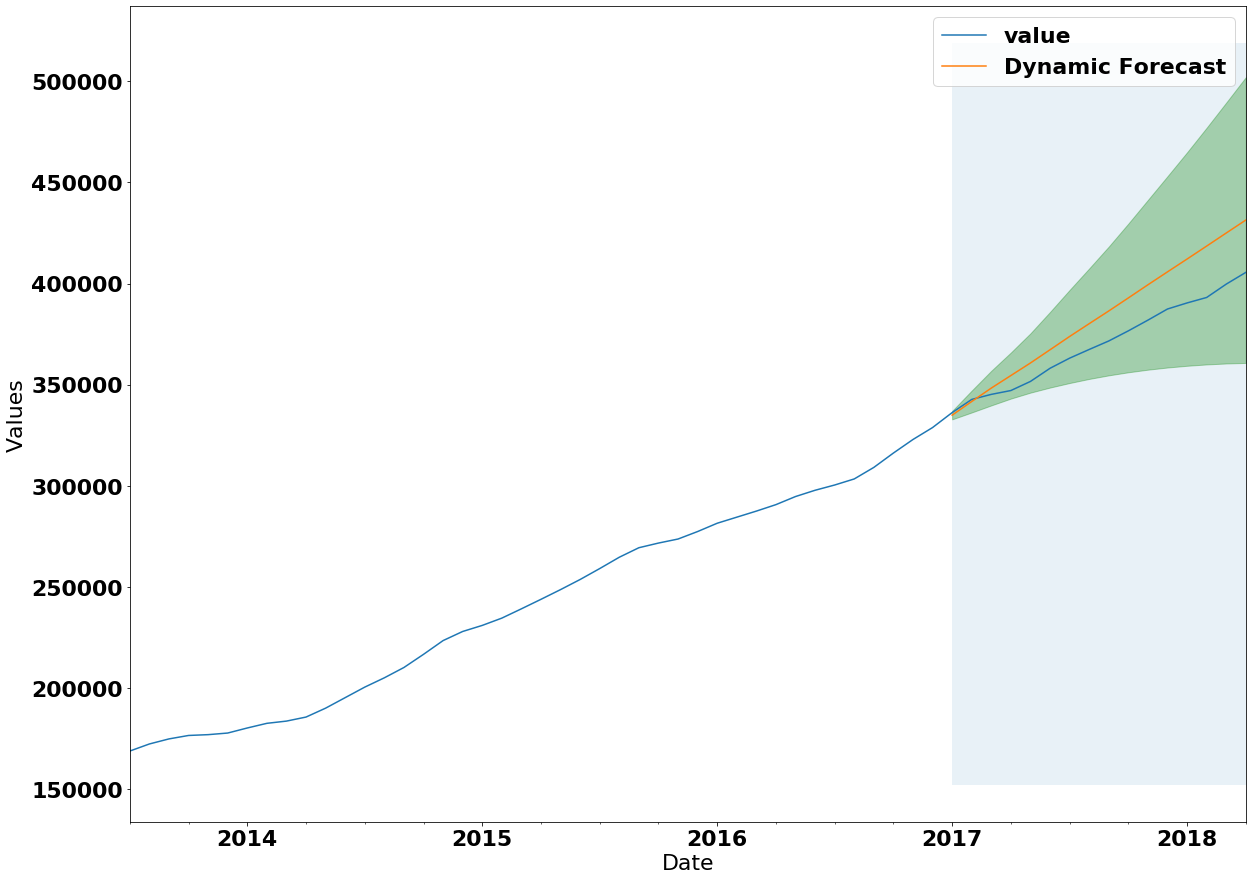

The Mean Squared Error of our forecasts is 253958983.37


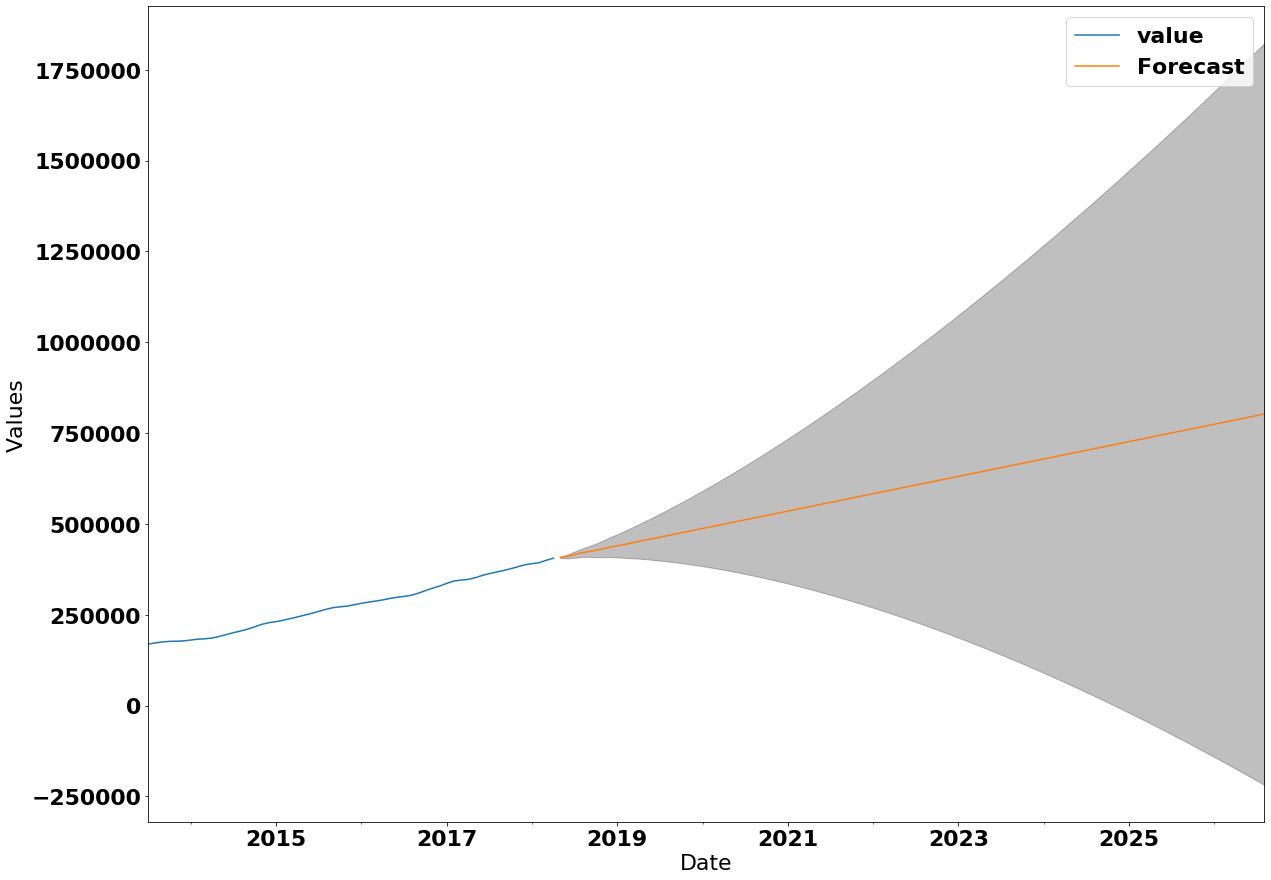

In [220]:
basic_arima_test(san_fran_model_df)

ARIMA (0, 0, 0) : AIC Caluculated =6626.487257280547
ARIMA (0, 0, 1) : AIC Caluculated =6410.4588772281095
ARIMA (0, 0, 2) : AIC Caluculated =6344.412241343772
ARIMA (0, 1, 0) : AIC Caluculated =4105.1388892324685
ARIMA (0, 1, 1) : AIC Caluculated =3817.050875810763
ARIMA (0, 1, 2) : AIC Caluculated =3649.544802601964
ARIMA (0, 2, 0) : AIC Caluculated =3580.7057574074543
ARIMA (0, 2, 1) : AIC Caluculated =3539.8487241723733
ARIMA (0, 2, 2) : AIC Caluculated =3528.322981089792
ARIMA (1, 0, 0) : AIC Caluculated =4042.7406382621175
ARIMA (1, 0, 1) : AIC Caluculated =3768.753954232977
ARIMA (1, 0, 2) : AIC Caluculated =3705.193063342923
ARIMA (1, 1, 0) : AIC Caluculated =3587.5419214022318
ARIMA (1, 1, 1) : AIC Caluculated =3538.6930327239297
ARIMA (1, 1, 2) : AIC Caluculated =3527.89578806569
ARIMA (1, 2, 0) : AIC Caluculated =3559.618939613869
ARIMA (1, 2, 1) : AIC Caluculated =3541.1247140626683
ARIMA (1, 2, 2) : AIC Caluculated =3530.3662855150747
ARIMA (2, 0, 0) : AIC Caluculated =358

C:\Users\Andy\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Andy\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) : AIC Caluculated =3553.356839061438
ARIMA (2, 0, 2) : AIC Caluculated =3537.4142047794935
ARIMA (2, 1, 0) : AIC Caluculated =3543.269304452069
ARIMA (2, 1, 1) : AIC Caluculated =3540.536142256613
ARIMA (2, 1, 2) : AIC Caluculated =3528.5103322190434
ARIMA (2, 2, 0) : AIC Caluculated =3543.6255340680336
ARIMA (2, 2, 1) : AIC Caluculated =3542.736496922691
ARIMA (2, 2, 2) : AIC Caluculated =3529.803013883118
The lowest AIC value is 3527.89578806569 with a p, d, q of (1, 1, 2)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8738      0.034     25.448      0.000       0.807       0.941
ma.L1          0.4455      0.051      8.725      0.000       0.345       0.546
ma.L2          0.0081      0.056      0.145      0.885      -0.101       0.118
sigma2      4.212e+04   2583.357     16.303      0.000    3.71e+04    4.72e+04


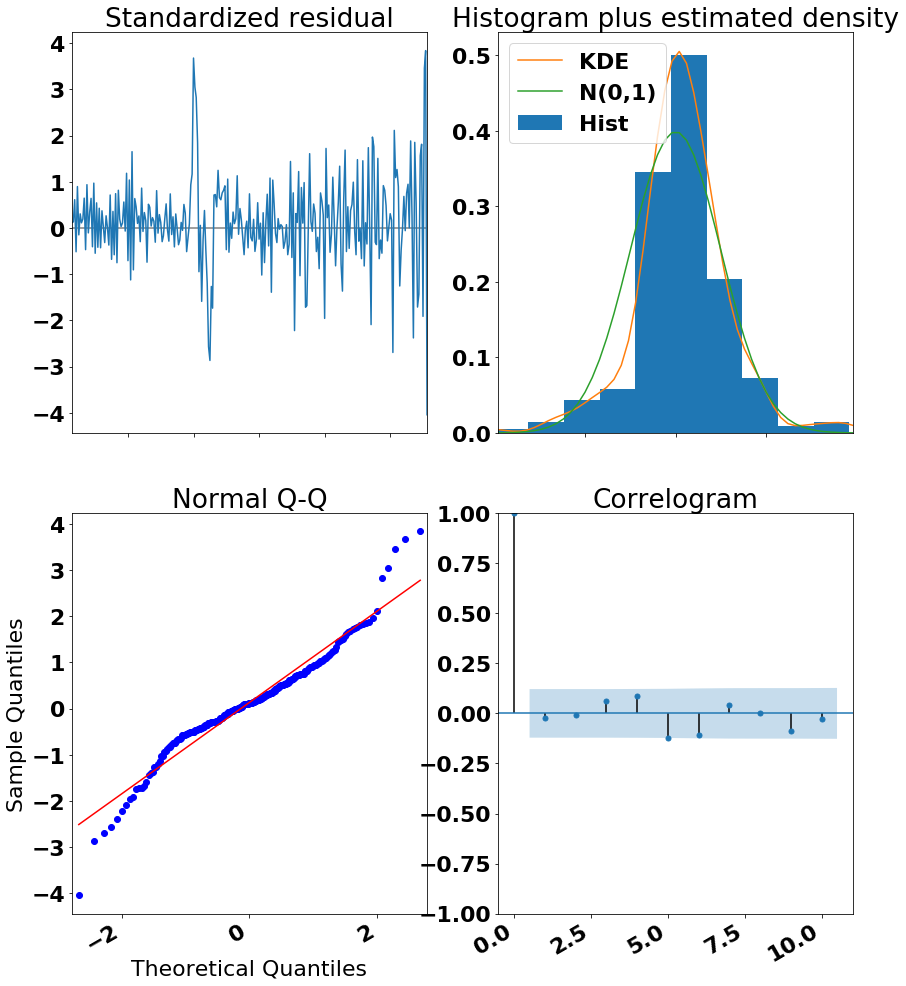

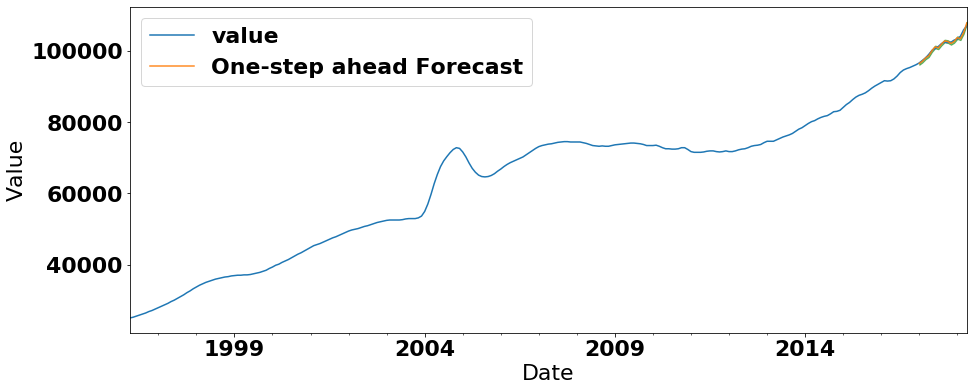

The Mean Squared Error of our forecasts is 189213.17


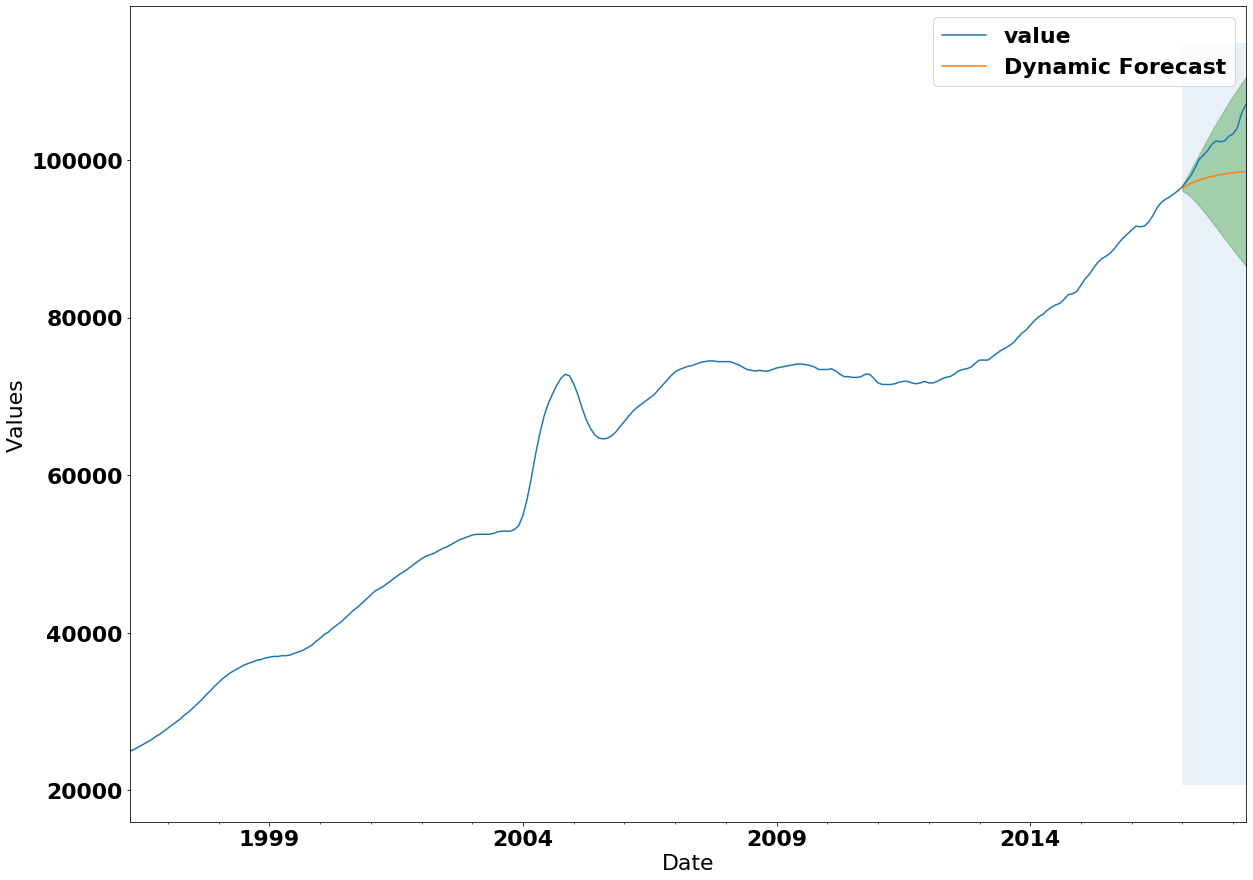

The Mean Squared Error of our forecasts is 19298260.79


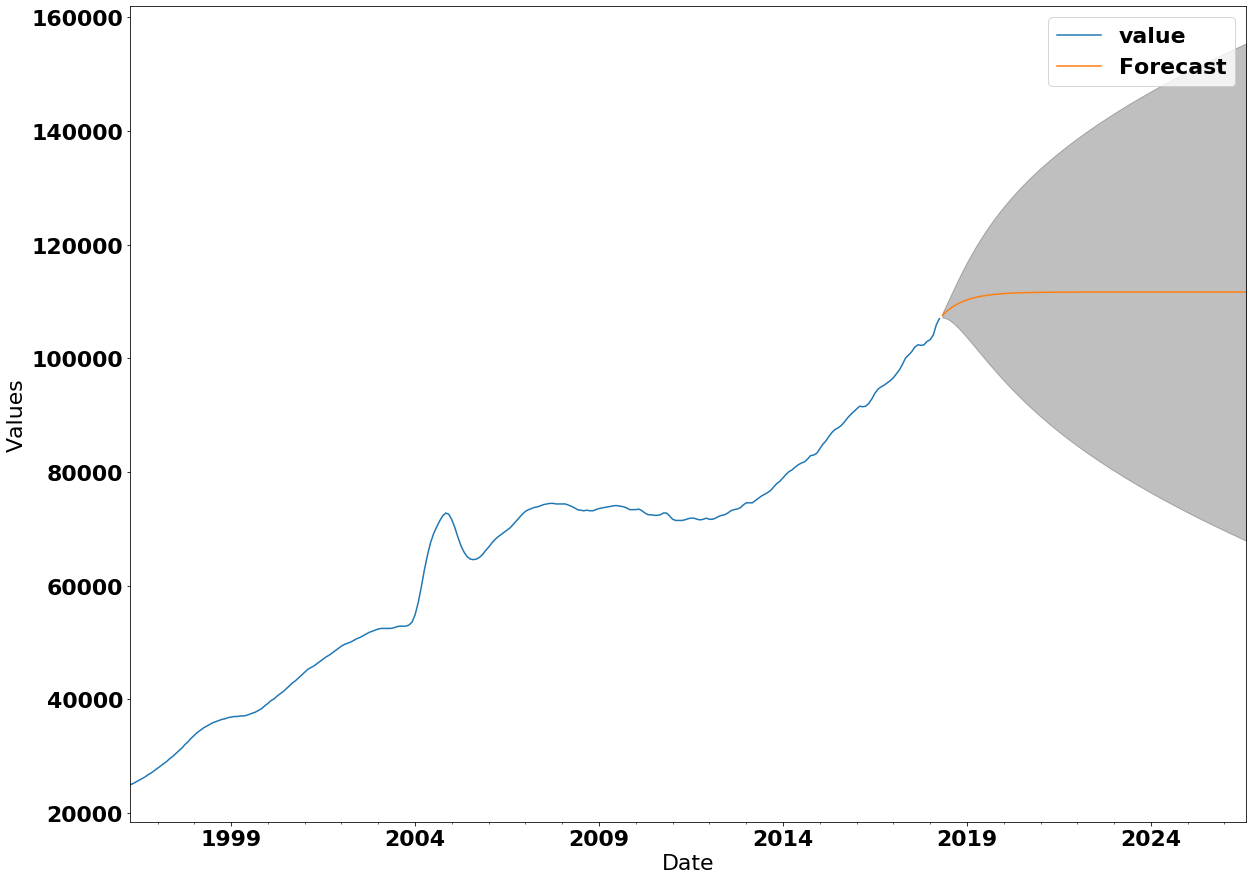

In [221]:
basic_arima_test(austin_model_df)

ARIMA (0, 0, 0) : AIC Caluculated =7062.665550581319
ARIMA (0, 0, 1) : AIC Caluculated =6845.703307631915
ARIMA (0, 0, 2) : AIC Caluculated =6777.523383187701
ARIMA (0, 1, 0) : AIC Caluculated =4611.767416534096
ARIMA (0, 1, 1) : AIC Caluculated =4270.773254826437
ARIMA (0, 1, 2) : AIC Caluculated =4015.149732702125
ARIMA (0, 2, 0) : AIC Caluculated =3814.7948949911934
ARIMA (0, 2, 1) : AIC Caluculated =3746.804456656542
ARIMA (0, 2, 2) : AIC Caluculated =3733.491152058554
ARIMA (1, 0, 0) : AIC Caluculated =4579.694433676033
ARIMA (1, 0, 1) : AIC Caluculated =4358.838961186771


C:\Users\Andy\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) : AIC Caluculated =3996.54262197311
ARIMA (1, 1, 0) : AIC Caluculated =3827.905325579554
ARIMA (1, 1, 1) : AIC Caluculated =3758.339664943349
ARIMA (1, 1, 2) : AIC Caluculated =3743.1336929068743
ARIMA (1, 2, 0) : AIC Caluculated =3777.403358621555
ARIMA (1, 2, 1) : AIC Caluculated =3746.862228150223
ARIMA (1, 2, 2) : AIC Caluculated =3733.2360291434306
ARIMA (2, 0, 0) : AIC Caluculated =3829.518792591241
ARIMA (2, 0, 1) : AIC Caluculated =3819.7137336267447
ARIMA (2, 0, 2) : AIC Caluculated =3757.942963733279
ARIMA (2, 1, 0) : AIC Caluculated =3772.1627380127734
ARIMA (2, 1, 1) : AIC Caluculated =3757.0557263709024
ARIMA (2, 1, 2) : AIC Caluculated =3745.0320099180085
ARIMA (2, 2, 0) : AIC Caluculated =3748.5408396616695
ARIMA (2, 2, 1) : AIC Caluculated =3750.3208612943054
ARIMA (2, 2, 2) : AIC Caluculated =3736.9176632551735
The lowest AIC value is 3733.2360291434306 with a p, d, q of (1, 2, 2)
                 coef    std err          z      P>|z|      [0.025      0

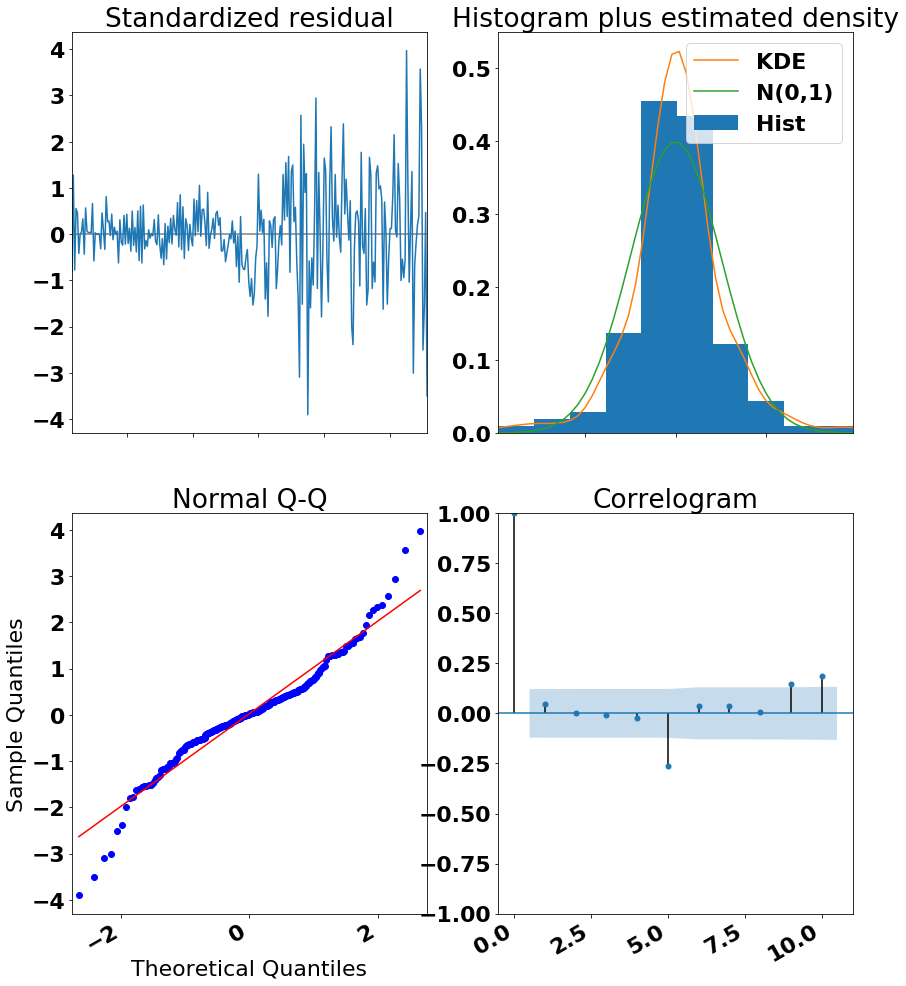

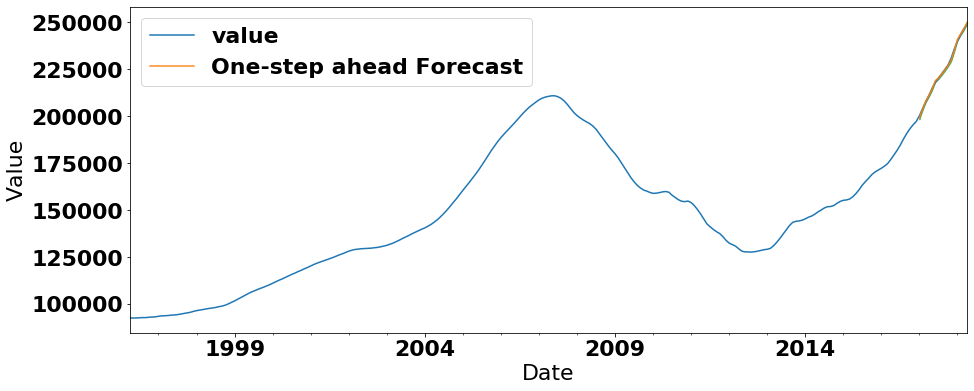

The Mean Squared Error of our forecasts is 418834.29


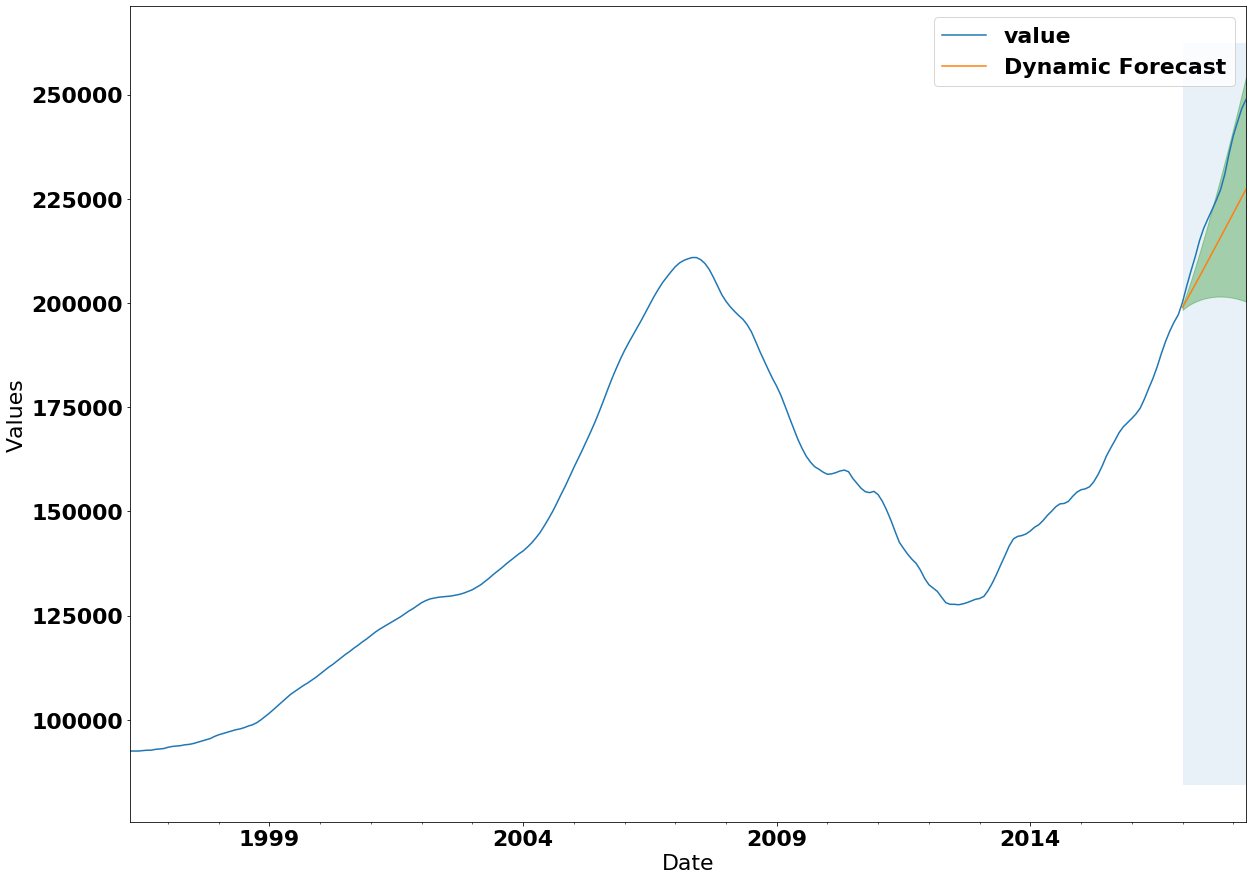

The Mean Squared Error of our forecasts is 175327113.1


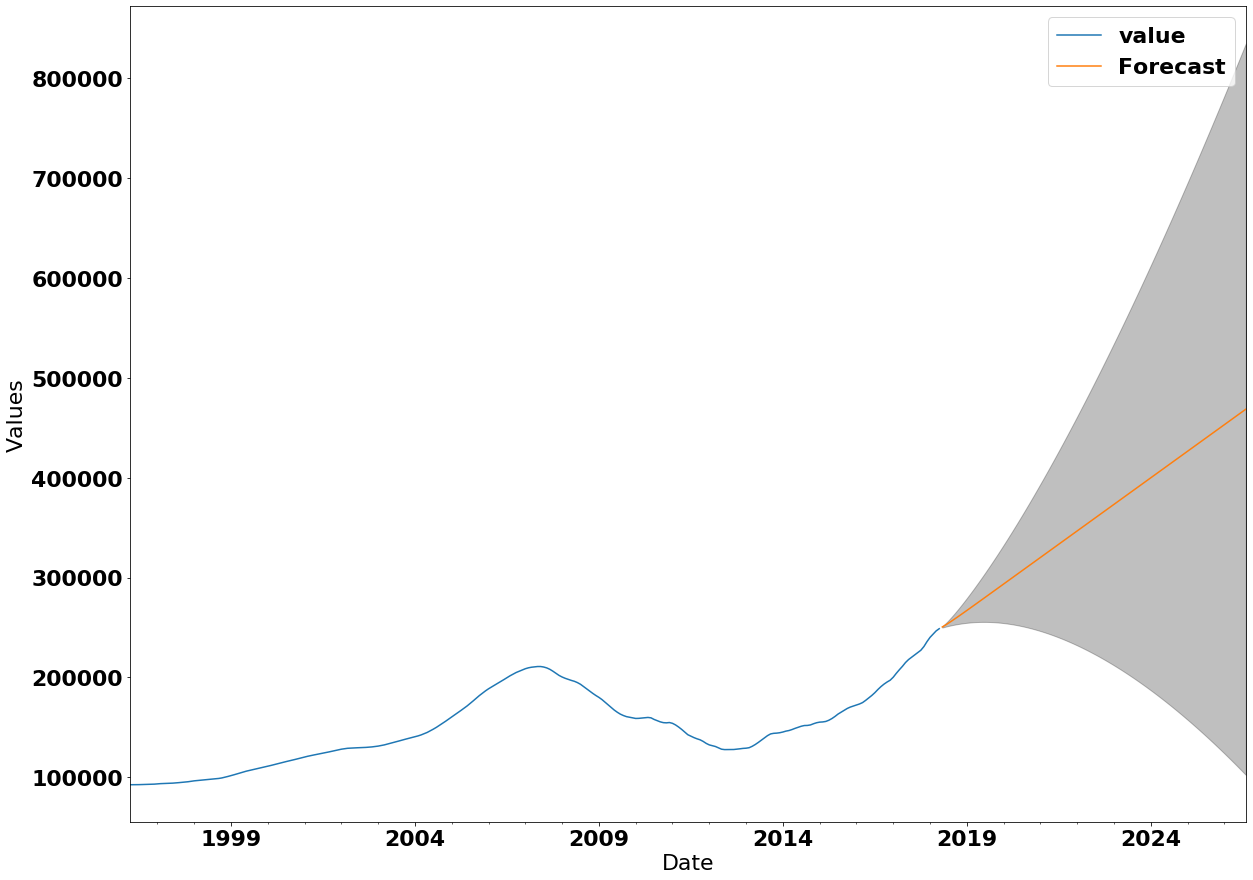

In [222]:
basic_arima_test(seattle_model_df)

ARIMA (0, 0, 0) : AIC Caluculated =6498.6033412142
ARIMA (0, 0, 1) : AIC Caluculated =6283.730583517629
ARIMA (0, 1, 0) : AIC Caluculated =4186.004559915457
ARIMA (0, 1, 1) : AIC Caluculated =3956.2799005227826
ARIMA (1, 0, 0) : AIC Caluculated =4185.258536088061
ARIMA (1, 0, 1) : AIC Caluculated =3961.6511955651404
ARIMA (1, 1, 0) : AIC Caluculated =4017.2659237000044
ARIMA (1, 1, 1) : AIC Caluculated =3907.5262407064697
The lowest AIC value is 3907.5262407064697 with a p, d, q of (1, 1, 1)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4686      0.047      9.988      0.000       0.377       0.560
ma.L1          0.7011      0.039     17.869      0.000       0.624       0.778
sigma2      1.787e+05   9748.128     18.337      0.000     1.6e+05    1.98e+05


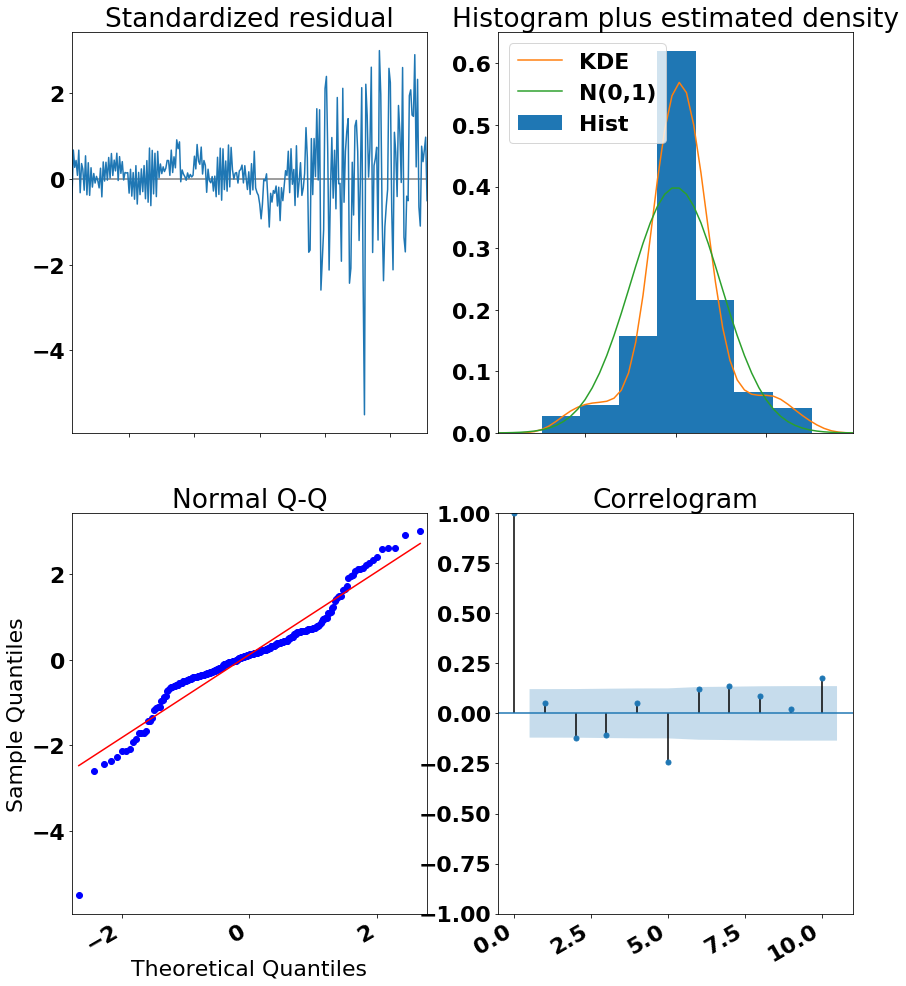

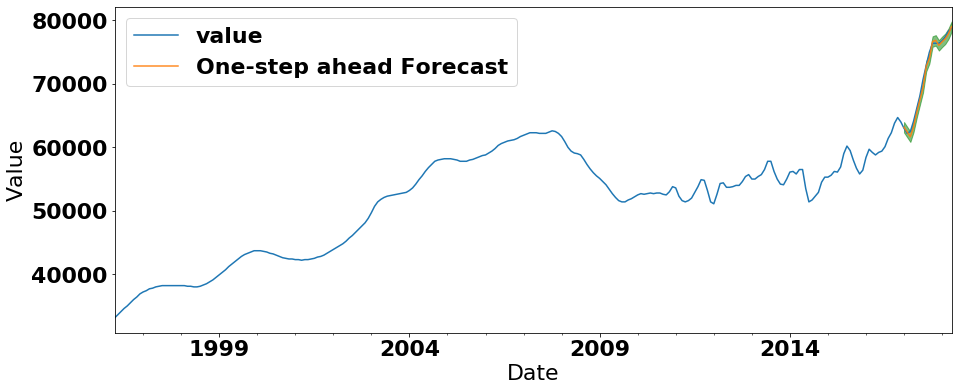

The Mean Squared Error of our forecasts is 345930.26


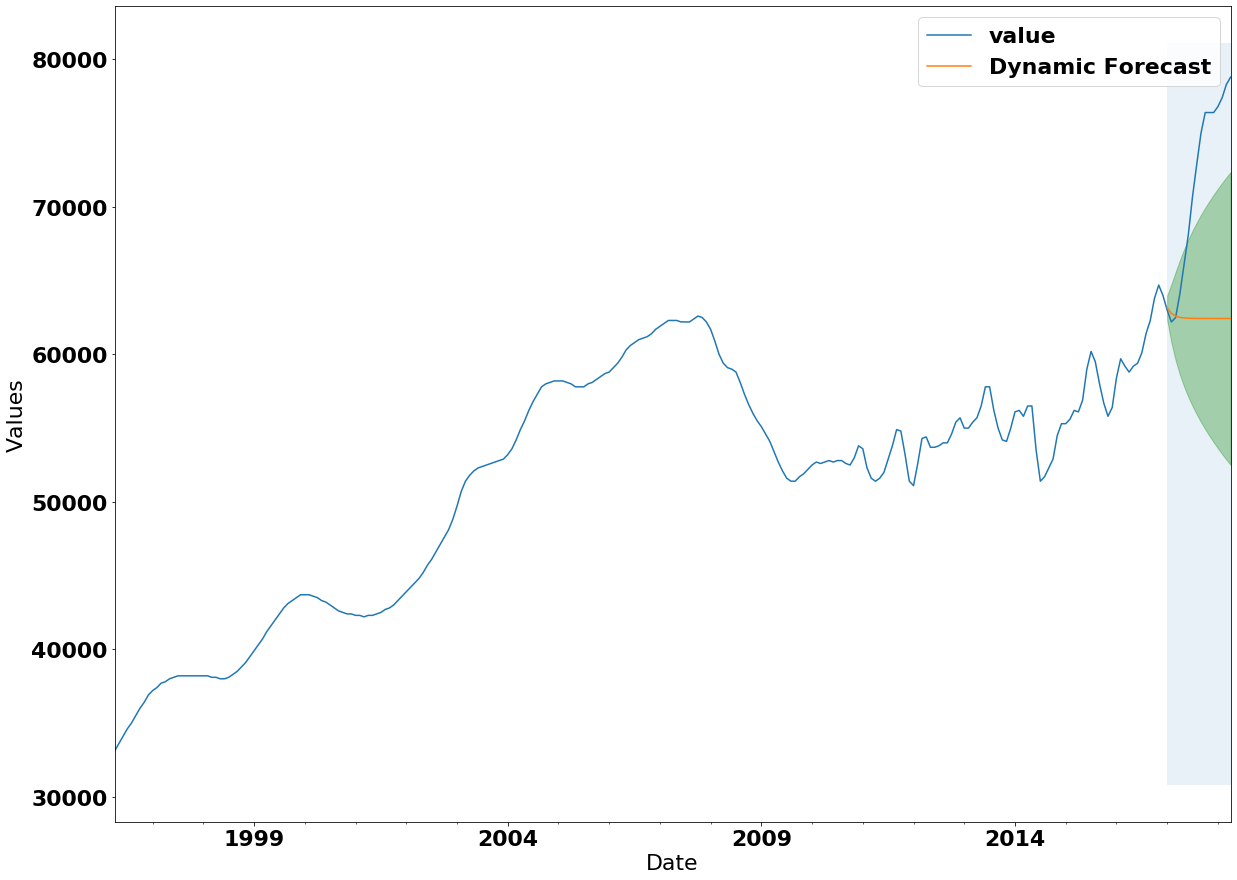

The Mean Squared Error of our forecasts is 119890861.47


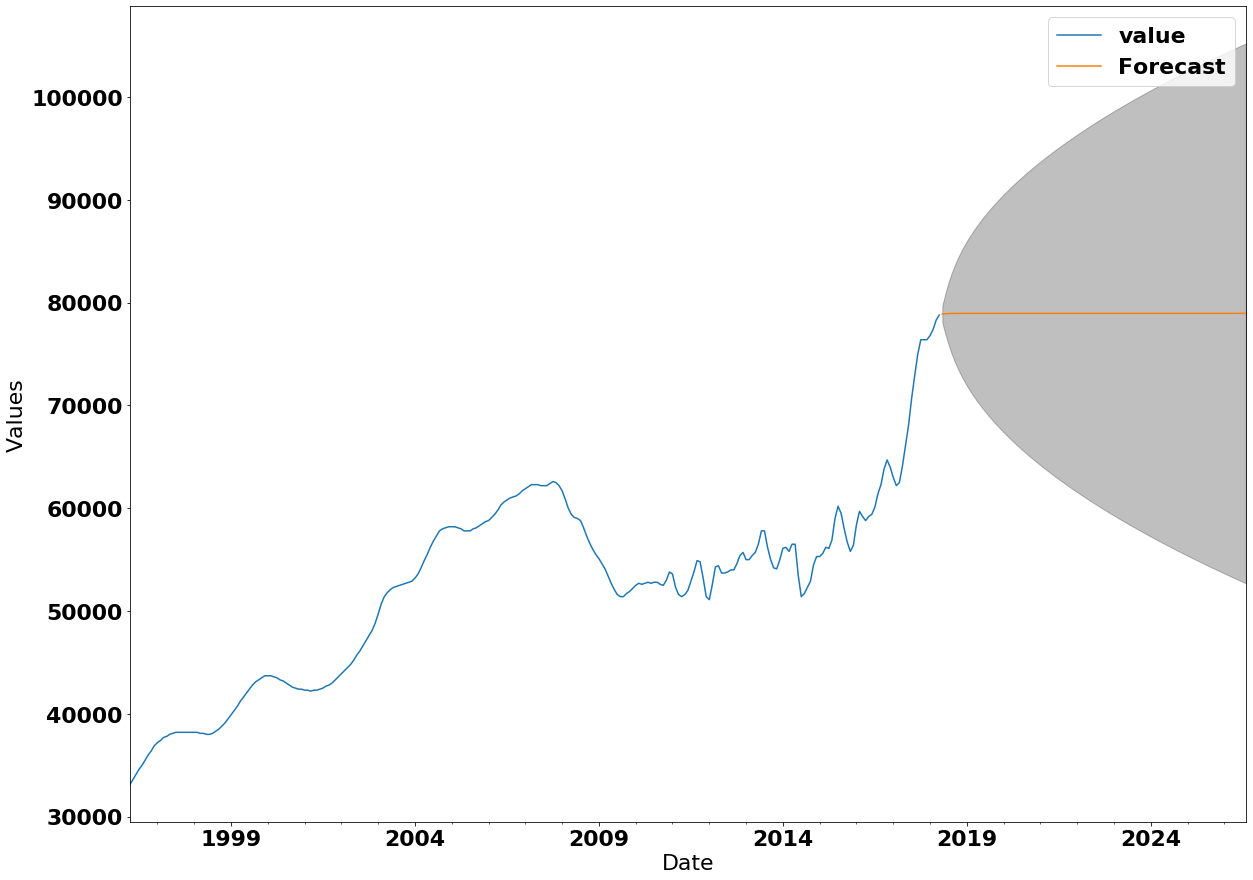

In [225]:
basic_arima_test(dallas_model_df)

ARIMA (0, 0, 0) : AIC Caluculated =6971.800912912142
ARIMA (0, 0, 1) : AIC Caluculated =6754.950187828368
ARIMA (0, 1, 0) : AIC Caluculated =4654.6023871647185
ARIMA (0, 1, 1) : AIC Caluculated =4401.576830041344
ARIMA (1, 0, 0) : AIC Caluculated =4664.260658150561
ARIMA (1, 0, 1) : AIC Caluculated =4393.417210307796
ARIMA (1, 1, 0) : AIC Caluculated =4348.645025955882
ARIMA (1, 1, 1) : AIC Caluculated =4235.162684044801
The lowest AIC value is 4235.162684044801 with a p, d, q of (1, 1, 1)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7173      0.030     23.798      0.000       0.658       0.776
ma.L1          0.6079      0.025     24.205      0.000       0.559       0.657
sigma2       5.56e+05   2.01e+04     27.694      0.000    5.17e+05    5.95e+05


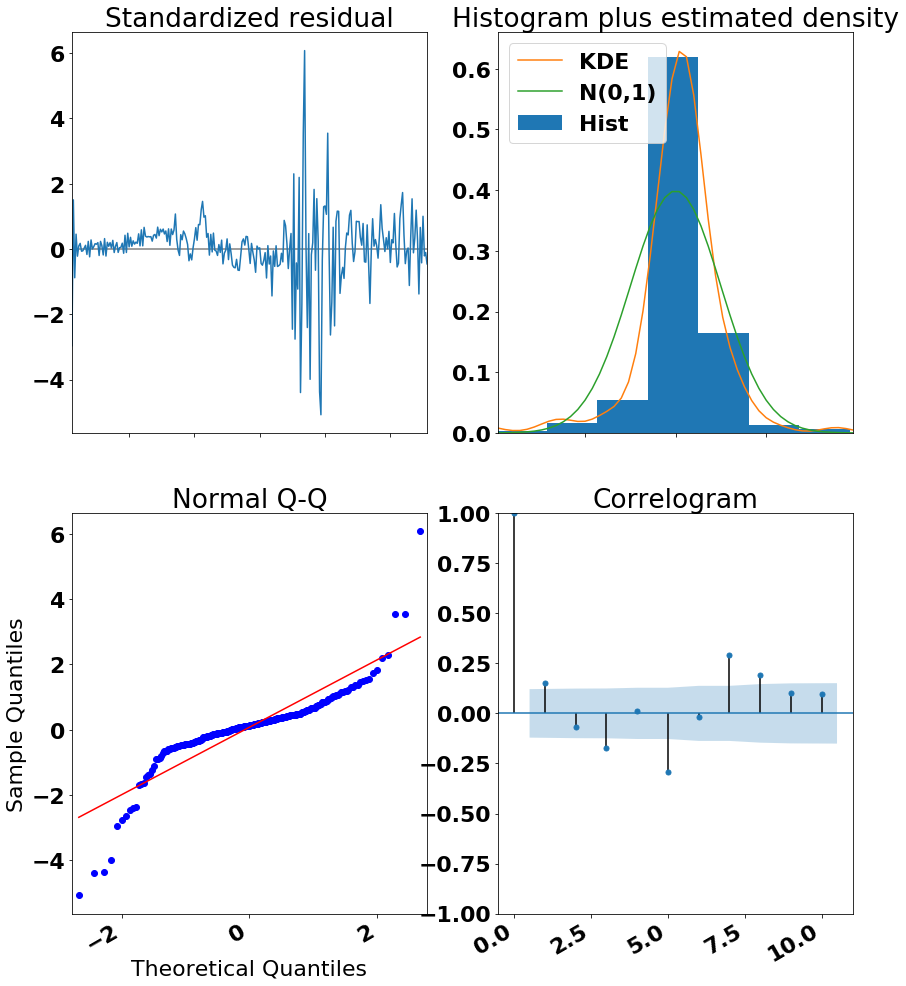

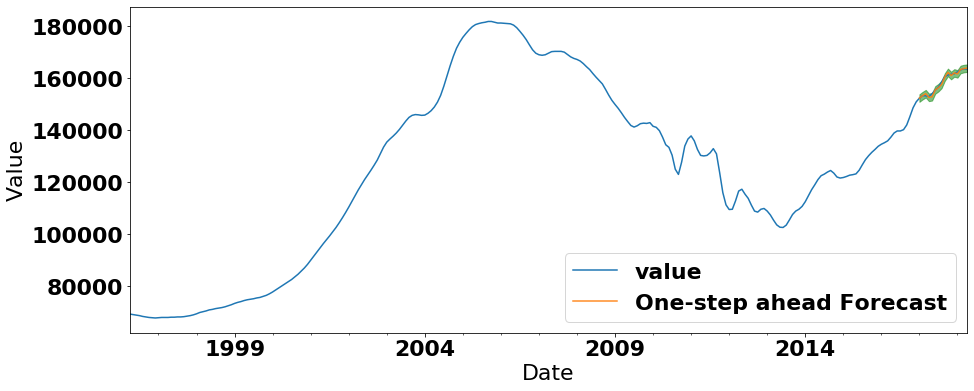

The Mean Squared Error of our forecasts is 317801.14


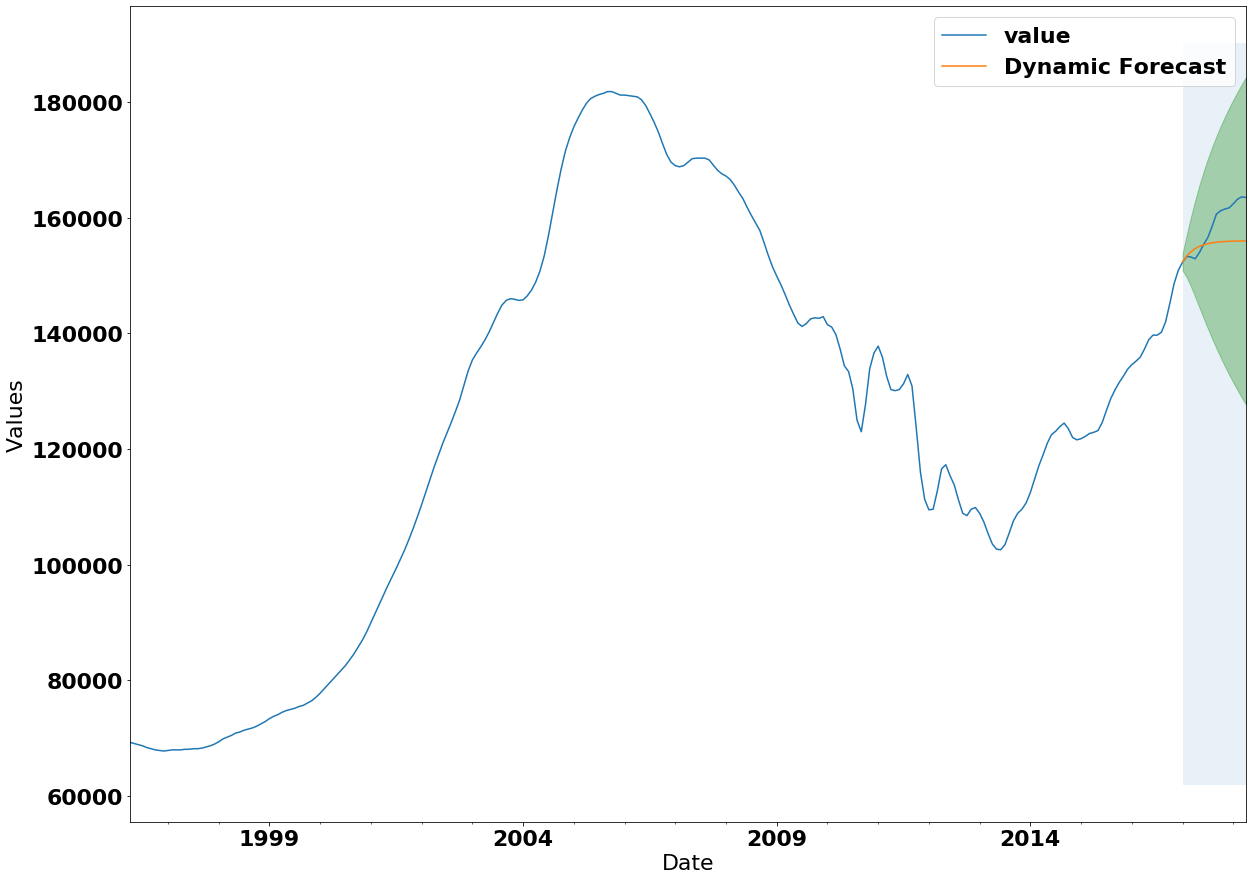

The Mean Squared Error of our forecasts is 21229132.54


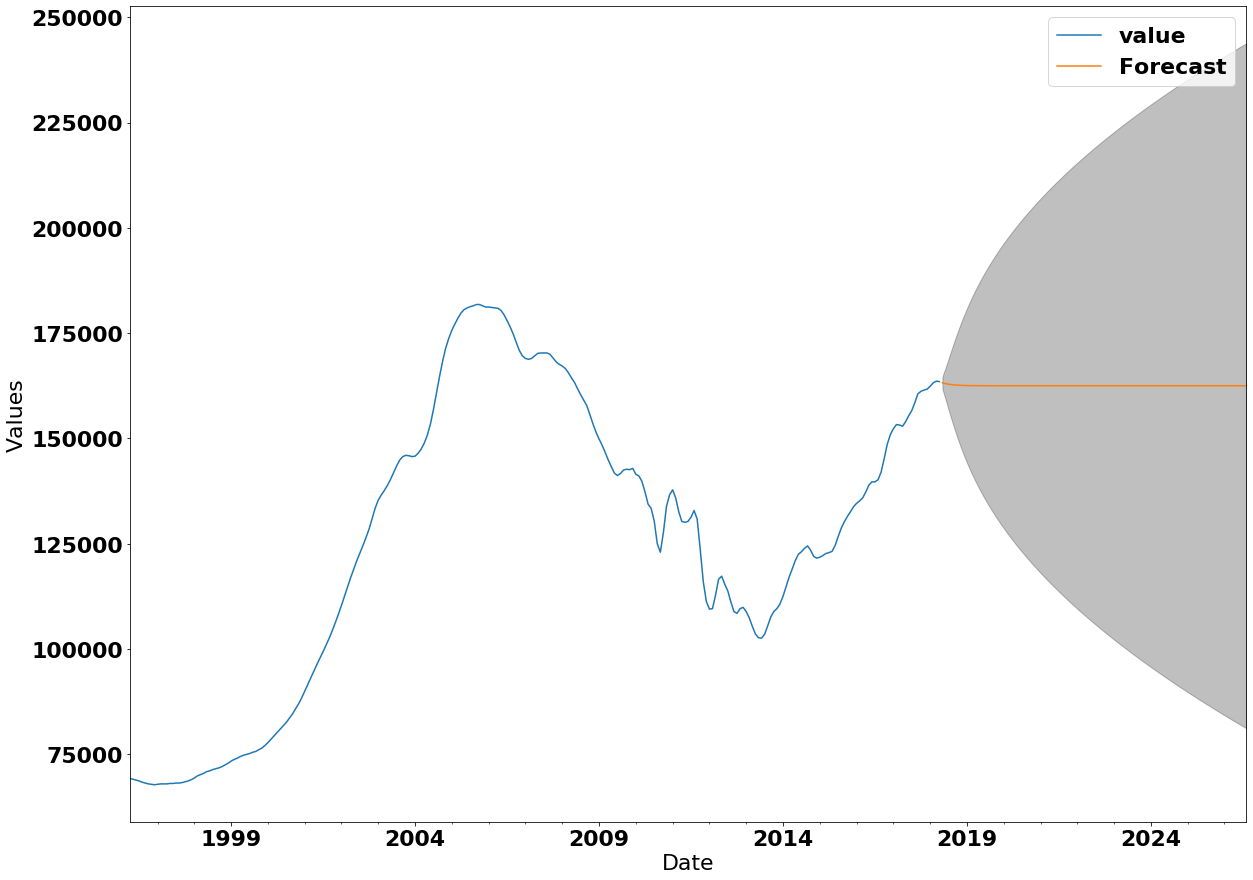

In [226]:
basic_arima_test(boston_model_df)

# Step 6: Interpreting Results